In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict, Counter
from konlpy.tag import Okt
from datetime import datetime
import os
from wordcloud import WordCloud

In [8]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제21대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_21/팍스넷_21대_대선_테마주_크롤링_20250627.csv"
NAVER_PATH = "../01_데이터수집/비정형데이터/stock_community/output/csv/제21대_대선_테마주/"
POS_PATH = "../03_모델링/sentiment_dictionary/final_positive_dict.csv"
NEG_PATH = "../03_모델링/sentiment_dictionary/final_negative_dict.csv"

FIXED_START = datetime(2025, 5, 3)
FIXED_END = datetime(2025, 6, 10)

In [9]:
# ───────────── 데이터 로딩 ─────────────

####################### 팍스넷 데이터 ##################################
paxnet_df = pd.read_csv(PAXNET_PATH)
paxnet_df["날짜"] = pd.to_datetime(paxnet_df["날짜"])
#####################################################################



####################### 네이버 종토방 데이터 #############################
csv_files = [f for f in os.listdir(NAVER_PATH) if f.endswith(".csv")]   # 경로 내 csv 파일 목록 가져오기

dataframes = [] # concat 저장용

# 각 CSV 파일 읽어서 리스트에 추가
for file in csv_files:
    file_path = os.path.join(NAVER_PATH, file)
    try:
        df = pd.read_csv(file_path)
        df['filename'] = file  # 어떤 파일에서 왔는지 표시
        dataframes.append(df)
    except Exception as e:
        print(f"파일 읽기 오류: {file_path} → {e}")

naver_df = pd.concat(dataframes, ignore_index=True) # concat
naver_df['article_date'] = pd.to_datetime(naver_df['article_date'])
#####################################################################



###################### 긍정, 부전 사전 #################################
positive_df = pd.read_csv(POS_PATH)
negative_df = pd.read_csv(NEG_PATH)
sentiment_dict = {
    **dict(zip(positive_df["단어"], positive_df["최종점수"])),
    **dict(zip(negative_df["단어"], negative_df["최종점수"]))
}
#####################################################################

okt = Okt()  # 형태소 분석기 인스턴스 생성

In [10]:
# ───────────── 데이터 전처리 ─────────────
naver_selected_df = naver_df[["stock_name", "article_date", "article_title", "article_content"]].copy()
naver_selected_df.rename(columns={
    "stock_name": "종목명",
    "article_date": "날짜",
    "article_title": "제목",
    "article_content": "내용"
}, inplace=True)

paxnet_selected_df = paxnet_df[['종목명', '날짜', '제목', '내용']].copy()

stock_df = pd.concat([naver_selected_df, paxnet_selected_df], ignore_index=True)    # 데이터 병합
stock_df.sort_values(by='날짜', inplace=True)   # datetime 순서로 정렬
stock_df

,종목명,날짜,제목,내용
47452,평화홀딩스,2025-05-03,아니 김문수가 된다고??,답이없다 ㅉ
47374,평화홀딩스,2025-05-03,홍준표를 선거본부장으로 픽해라,덕수는 필요없다 홍카의 지략만 필요할뿐
47373,평화홀딩스,2025-05-03,이그~ 테마쥬 모르시는 겨?,아이규 ~~~ 테마쥬 모르시는뀨? 테마쥬는 돈놓고 돈먹는 도박 쥬여 ~ 정신 바짝 ...
47372,평화홀딩스,2025-05-03,왜 불안하지,금욜 도박성으로 물타고 오늘 경선승리했는데 왜 불안하지 시초 반짝 올리고 패대기 치...
47371,평화홀딩스,2025-05-03,와우 김문수ㅡㅡ대통령 안되도 좋은. 어린학생들에게 귀감?죄맹이하고는 급이다른인생!,"[단독]""내 남편 김문수,ㅡ 촌스럽지만 순수해…모두를 끌어안는 대통령 될 것"" []..."
...,...,...,...,...
13537,코나아이,2025-06-10,기본소득폐지는 얘한테 더 좋은거아님?,이상 지나가는 1주 관망자..
13538,코나아이,2025-06-10,지역화폐 증액,전국민 재난지원금은 코나아이에 의미없다..지역화폐 전문업체인 코나아이에겐 증액이 더...
13539,코나아이,2025-06-10,출렁출렁,어지럽네
13487,코나아이,2025-06-10,[삭제된 게시물의 답글]난 중국인이니까 250만원 주세요 리짜이밍 님!!,차이나 세쎄 니 하우머 베이징 니 여기서 뭐하고 있노 칭따오 어제 3명의 중국인 남...


In [11]:
# ───────────── 감성 점수 계산 함수 ─────────────
def compute_sentiment_by_date(df, stock_name, sentiment_dict, okt):
    score_by_date = defaultdict(float)
    for _, row in df[df["종목명"] == stock_name].iterrows():
        date = row["날짜"].date()
        text = f"{row['제목']} {row['내용']}"
        words = set(okt.morphs(text))
        score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
        score_by_date[date] += score
    return score_by_date

In [12]:
# ───────────── 종목별 감성 점수 및 주가 저장 ─────────────
all_stock_sentiment = {}
all_stock_prices = {}

for file_name in os.listdir(DATA_DIR):
    if not file_name.endswith(".csv"):
        continue

    file_path = os.path.join(DATA_DIR, file_name)
    price_df = pd.read_csv(file_path)
    price_df["Date"] = pd.to_datetime(price_df["Date"])
    price_df = price_df[(price_df["Date"] >= FIXED_START) & (price_df["Date"] <= FIXED_END)]

    if price_df.empty:
        continue

    stock_name = price_df["Name"].iloc[0]
    score_by_date = compute_sentiment_by_date(stock_df, stock_name, sentiment_dict, okt)

    sentiment_df = pd.DataFrame({
        "날짜": pd.to_datetime(list(score_by_date.keys())),
        "감성점수": list(score_by_date.values())
    }).sort_values("날짜")

    all_stock_sentiment[stock_name] = sentiment_df
    all_stock_prices[stock_name] = price_df

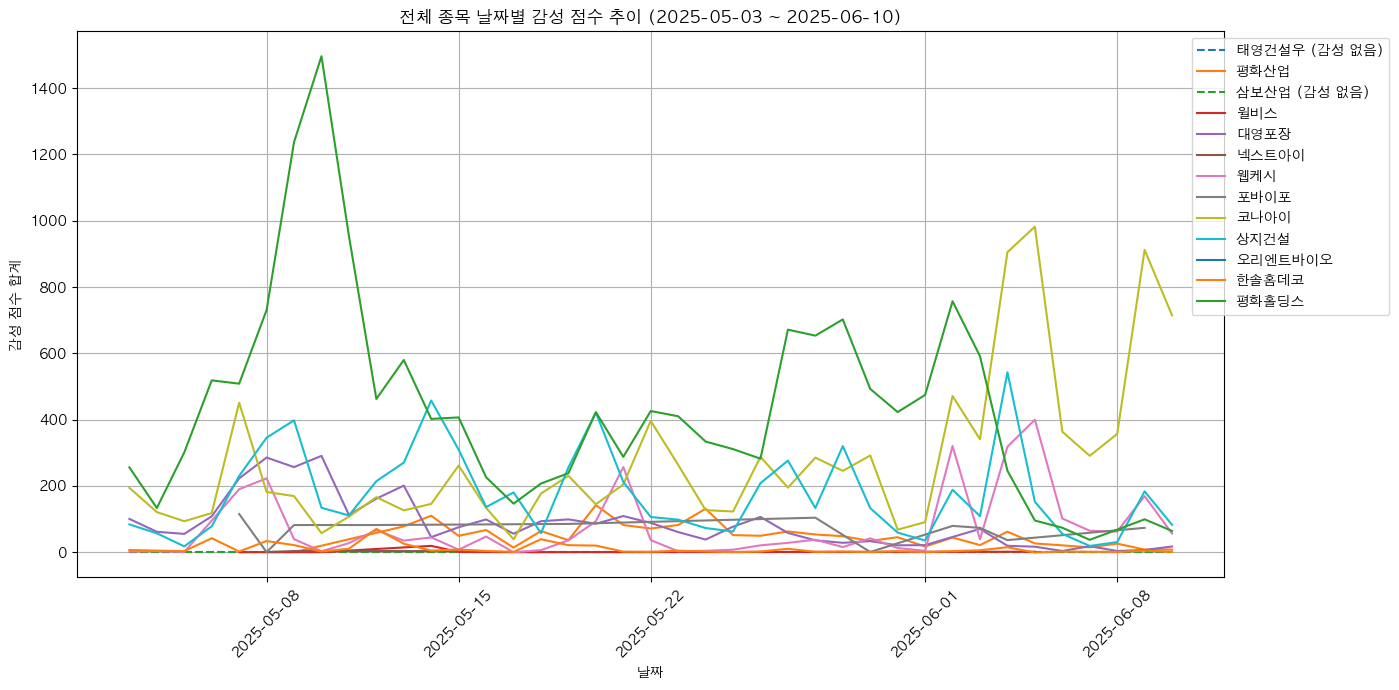

In [13]:
# ───────────── [1] 전체 종목 감성 점수 추이 ─────────────
plt.figure(figsize=(14, 7))

for stock, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    if filtered_sentiment.empty:
        # 날짜 축만 유지하고 y=0 값으로 대체
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', label=f"{stock} (감성 없음)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"], label=stock)

plt.title("전체 종목 날짜별 감성 점수 추이 (2025-05-03 ~ 2025-06-10)")
plt.xlabel("날짜")
plt.ylabel("감성 점수 합계")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ───────────── [2] 종목별 감성 점수만 시각화 ─────────────
for stock_name, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]

    plt.figure(figsize=(10, 4))
    if filtered_sentiment.empty:
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', color='gray')
        plt.title(f"{stock_name}: 감성 점수 없음 (2025-05-03 ~ 2025-06-10)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"],
                 marker='o', color='tab:red')
        plt.title(f"{stock_name}: 날짜별 감성 점수 추이 (2025-05-03 ~ 2025-06-10)")
    plt.xlabel("날짜")
    plt.ylabel("감성 점수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

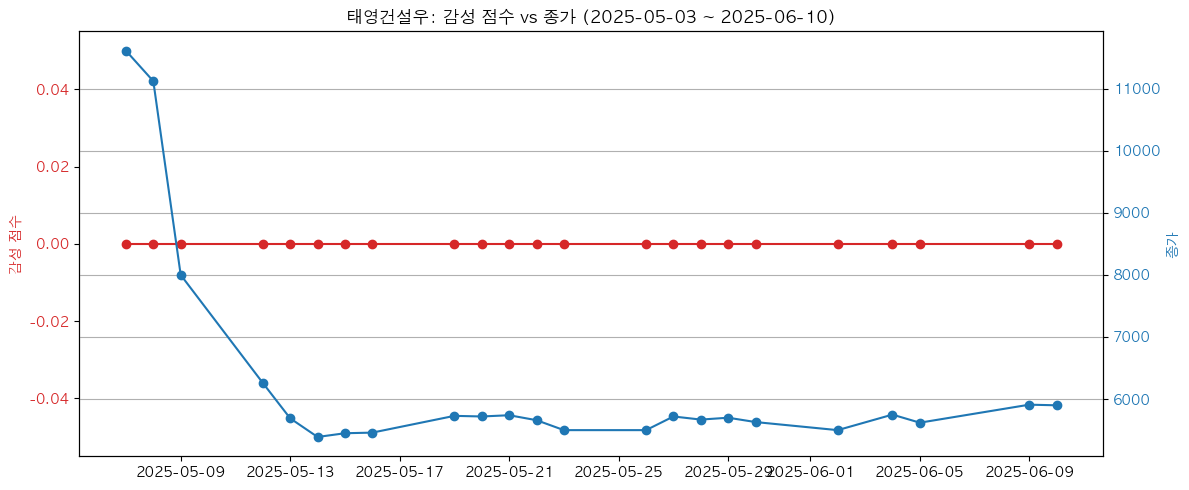

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.       0.      77.7751 109.9547  49.2054  66.8112  36.0047 142.0753
  81.7441  71.3199  81.9017  49.385   62.4787  53.324   48.1355  33.8353
  44.0644  61.7575  26.3045   7.73     7.8306]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


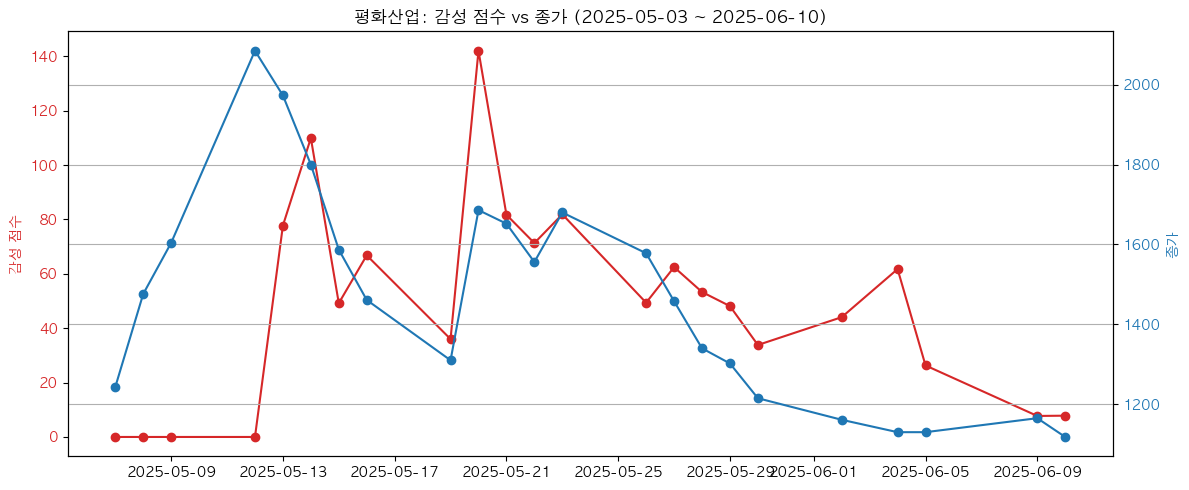

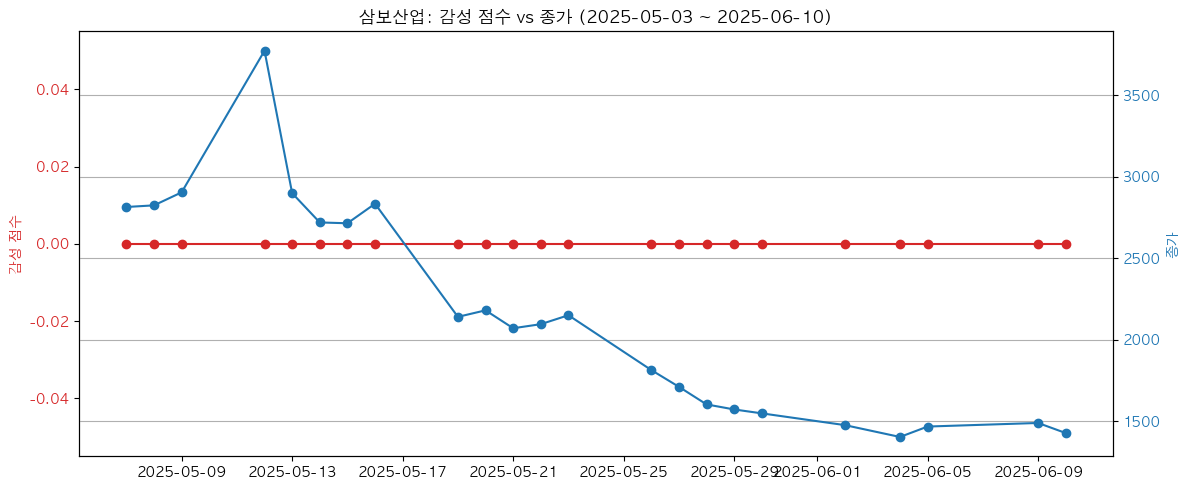

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.     18.9443  0.5662  1.2085]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


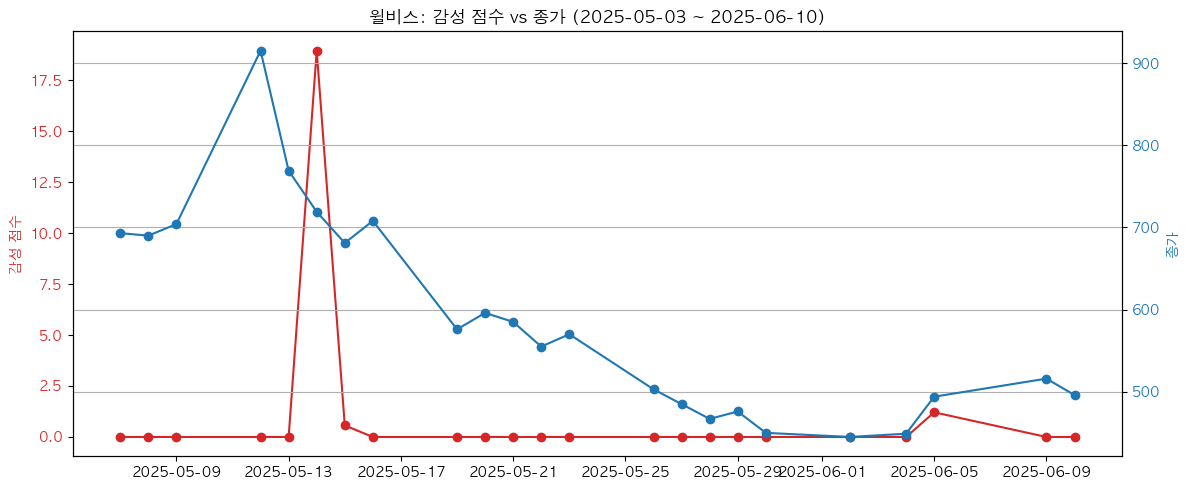

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[222.4525 285.487  256.642  161.3374 200.8147  45.2348  75.1454  98.6116
  98.8105  85.7785 108.8574  88.2173  60.5588 106.3817  57.9118  35.5659
  28.1423  33.1997  45.7927  19.1449  16.3512   6.6551  17.0293]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


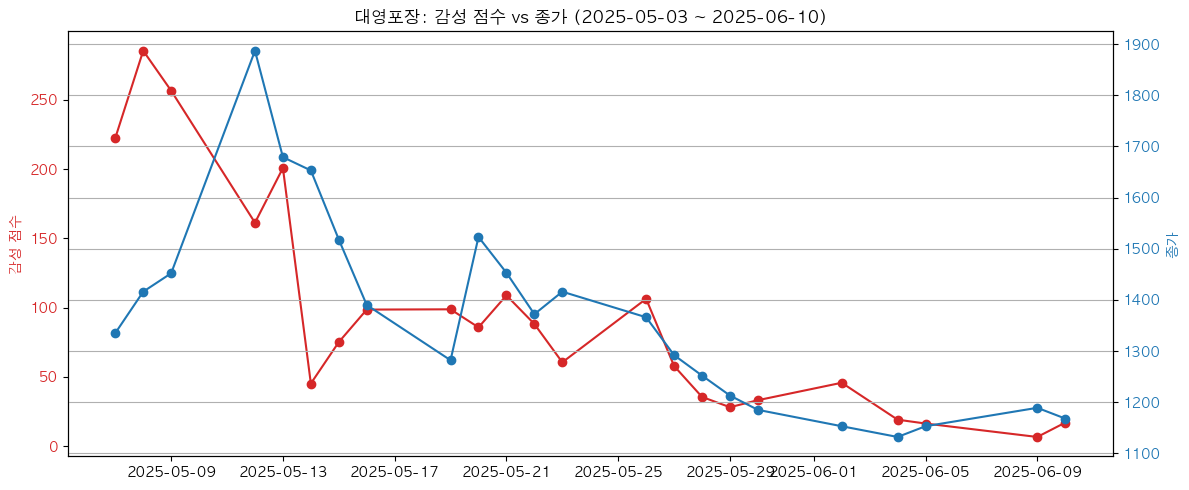

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.3398 3.291  3.0108]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


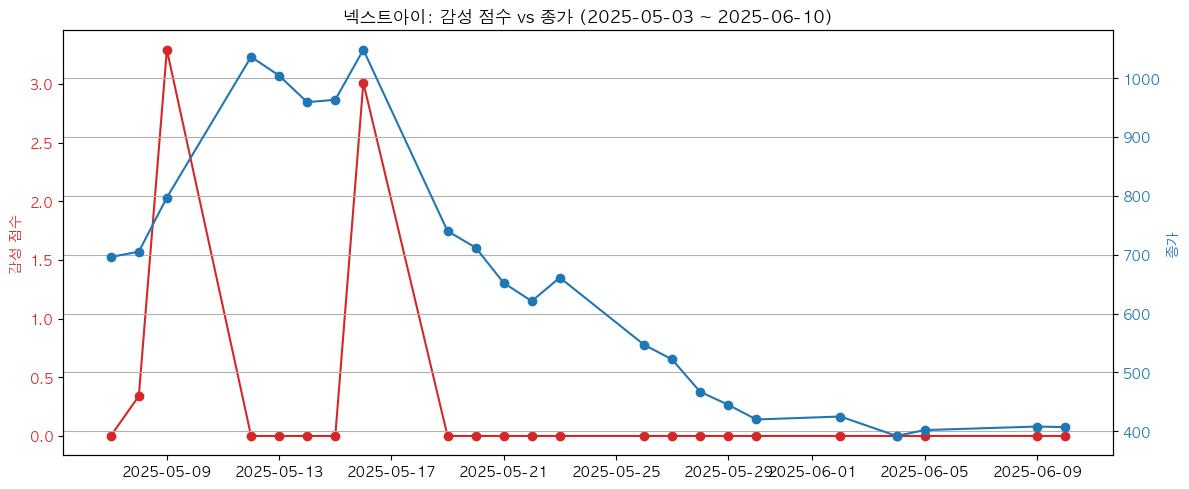

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[189.8988 222.6734  39.128   66.5165  34.7796  44.4817   7.4101  47.0531
  35.6944  93.2998 256.6878  36.2642   2.6887  20.5314  28.0926  37.5066
  15.3399  41.6357 320.2508 317.9552 399.6459 169.1029  56.078 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


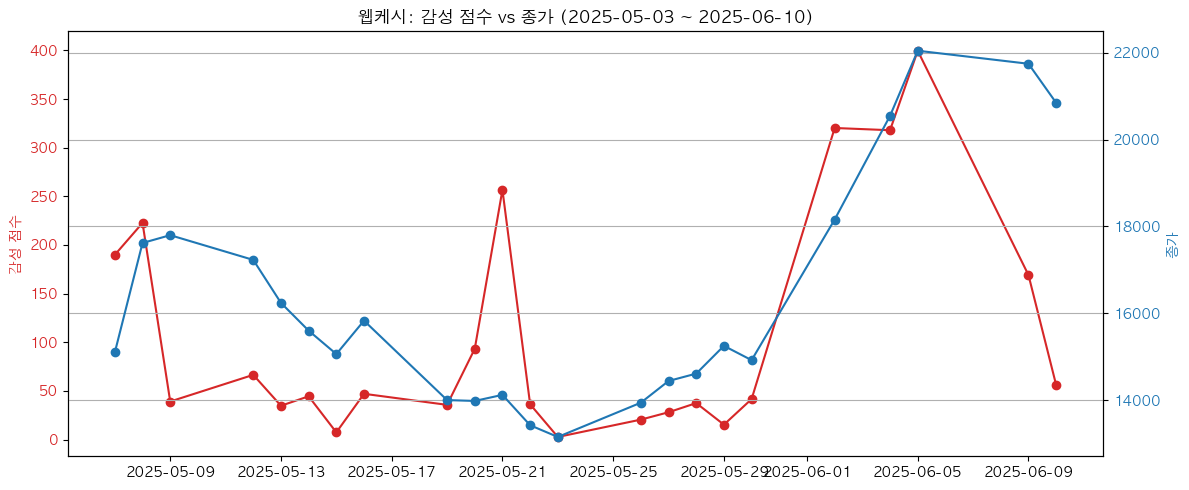

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[115.0947   0.      81.809   81.809   85.1767 103.97     0.4316  79.1802
  36.2854  73.3596]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


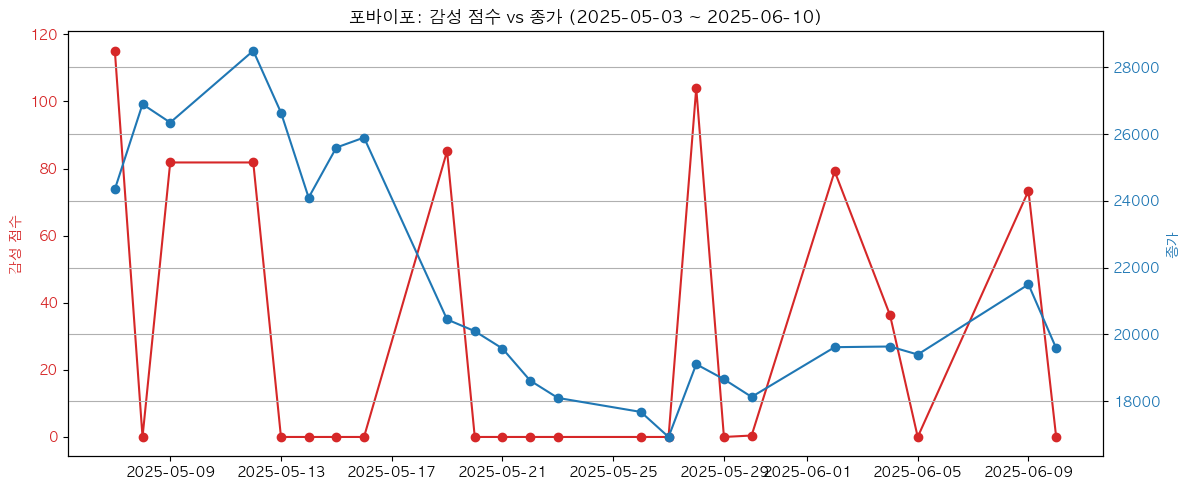

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[450.9753 181.6019 169.116  165.8252 126.1285 145.5445 261.2694 133.5636
 230.4205 144.3544 204.168  396.1756 263.4624 287.6556 194.6221 285.2353
 245.2735 291.5361 471.1365 905.2115 982.0871 912.1623 714.5432]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


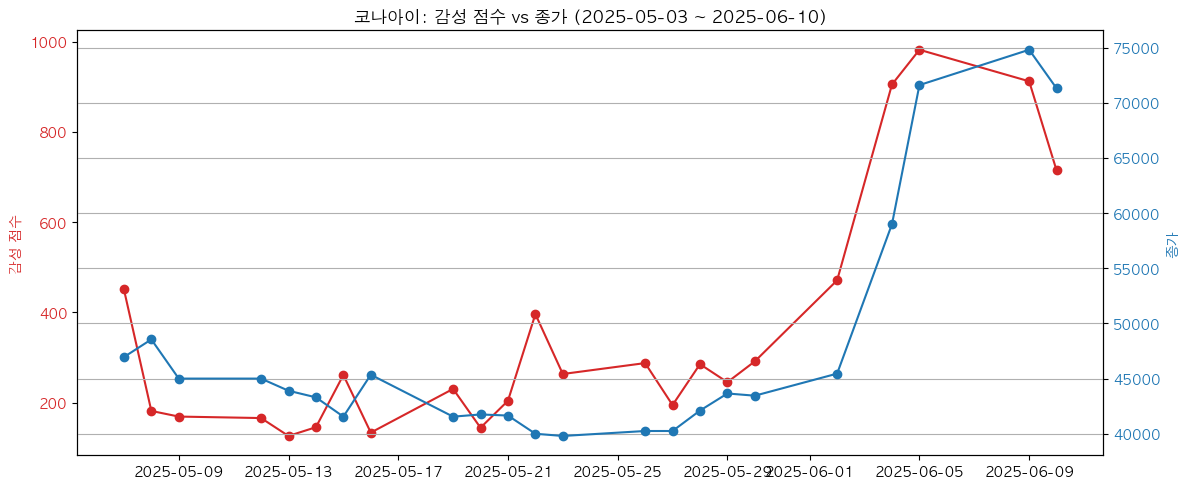

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[229.9885 345.3286 397.7192 270.0768 457.5422 309.1646 136.025  255.7084
 421.261  211.9289 106.0681  98.0356 208.0992 276.2393 133.0194 319.9535
 132.8363 188.2148 542.662  151.9671 183.2785  82.2599]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


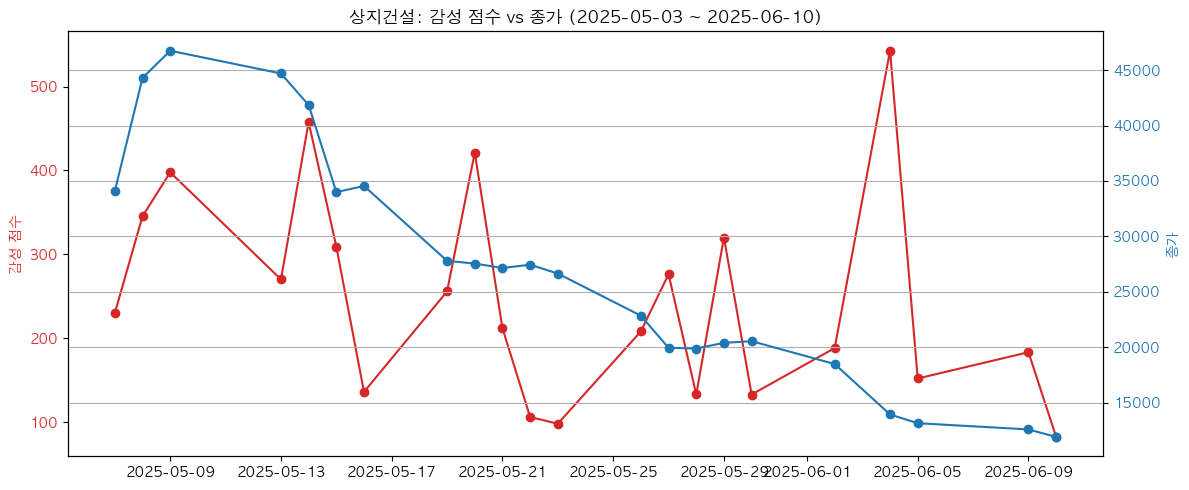

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.9564]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


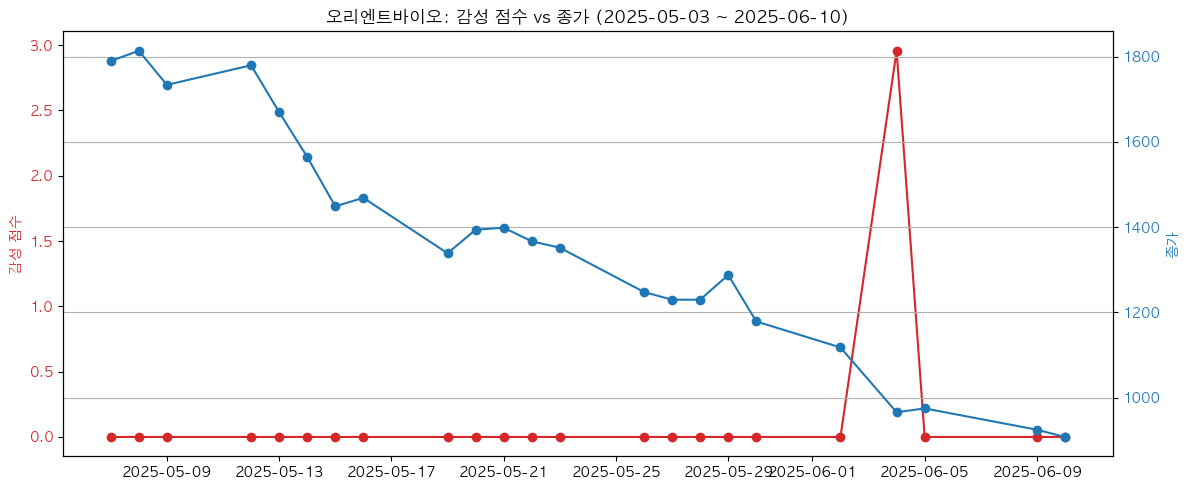

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.9483 33.5587 21.2085 70.0465 25.4464  4.6511  7.8263  3.5764 21.0028
 19.758   1.5579  1.1709  4.3784  1.9111 10.1602  0.9357  1.8503  0.3698
 14.8088 -1.212   4.5727  0.9001]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


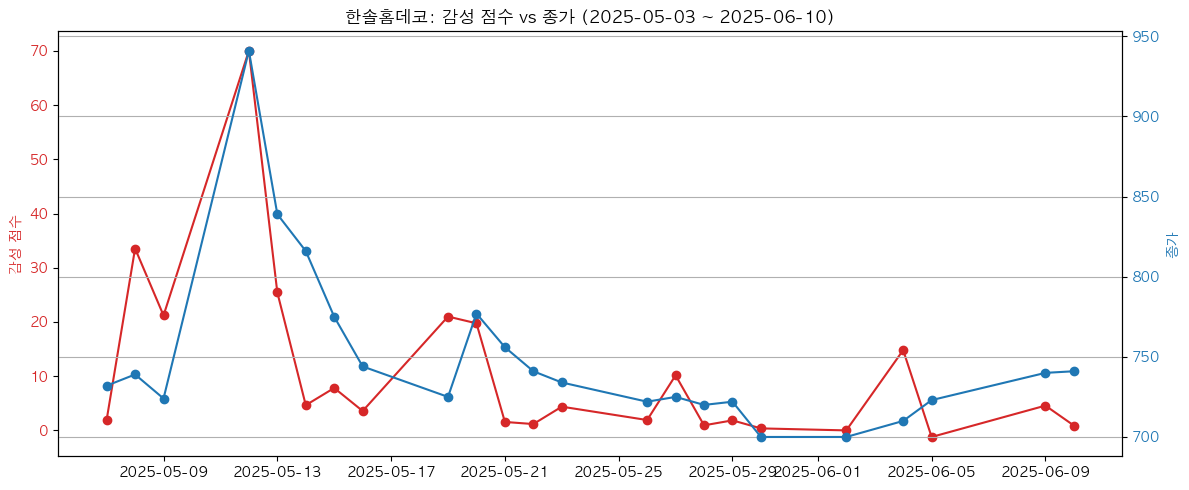

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_62007/36303492.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 508.4337  730.7181 1237.2308  462.2112  579.8797  402.0624  406.5829
  225.9912  238.2039  422.6733  287.5269  425.8001  410.0496  282.0773
  671.4559  653.3657  702.2417  492.5988  757.0843  245.7201   95.4491
   99.0967   63.9132]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


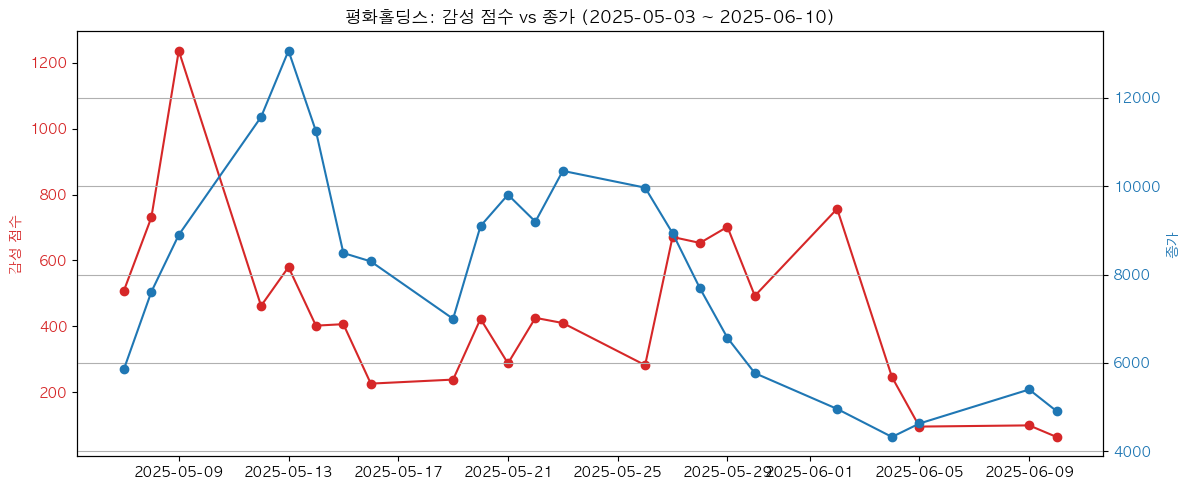

In [15]:
# ───────────── [3] 감성 점수 + 종가 시각화 ─────────────
for stock_name in all_stock_prices:
    price_df = all_stock_prices[stock_name]
    sentiment_df = all_stock_sentiment.get(stock_name, pd.DataFrame())

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # 감성 점수 시각화 (종가 날짜 기준으로 맞춤)
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) & 
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    base_dates = price_df["Date"]

    # 종가 기준 날짜에 맞춘 감성 점수 매핑 (없으면 0)
    sentiment_series = pd.Series(0, index=base_dates)
    sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])

    # 감성 점수 그래프
    ax1.plot(base_dates, sentiment_series.values, 
             color='tab:red', marker='o', linestyle='-', label="감성 점수")
    ax1.set_ylabel("감성 점수", color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 종가 그래프
    ax2 = ax1.twinx()
    ax2.plot(price_df["Date"], price_df["Close"],
             color='tab:blue', marker='o', linestyle='-', label="종가")
    ax2.set_ylabel("종가", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 제목 및 기타 설정
    plt.title(f"{stock_name}: 감성 점수 vs 종가 (2025-05-03 ~ 2025-06-10)")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

In [22]:
# 총 기간은 2025-03-28 ~ 2025-06-10
# 팍스넷 데이터가 2025-05-27부터 존재
# 2025-03-28 ~ 2025-05-26까지의 데이터가 비어 있음

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_77494/1682697835.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})


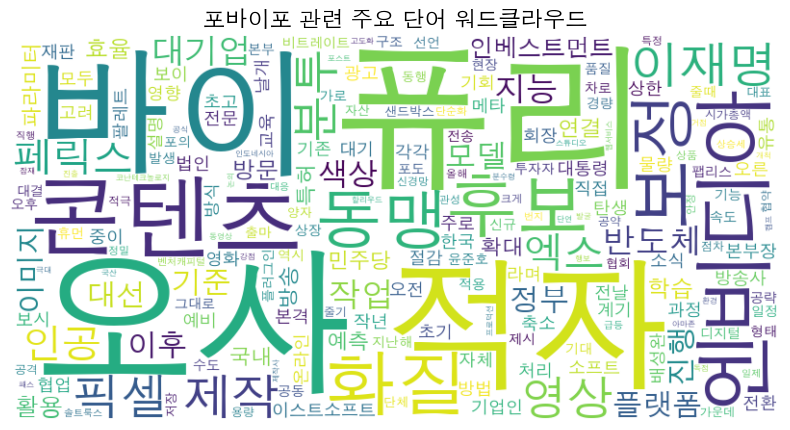

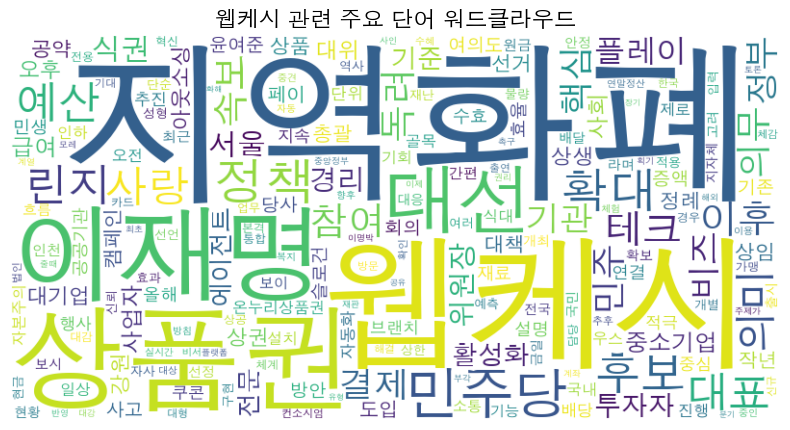

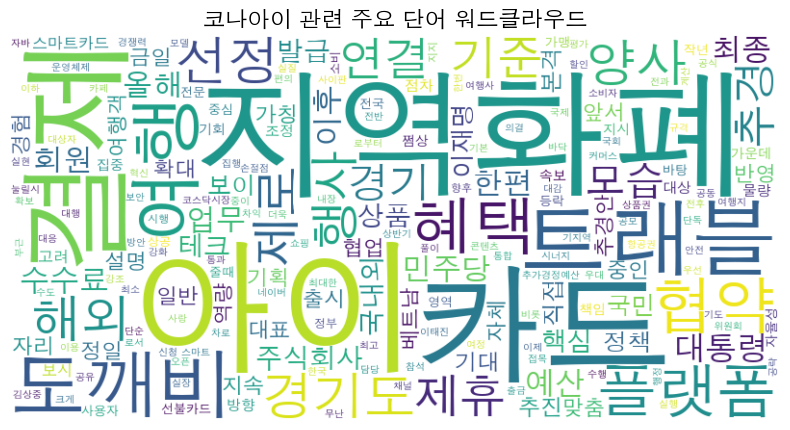

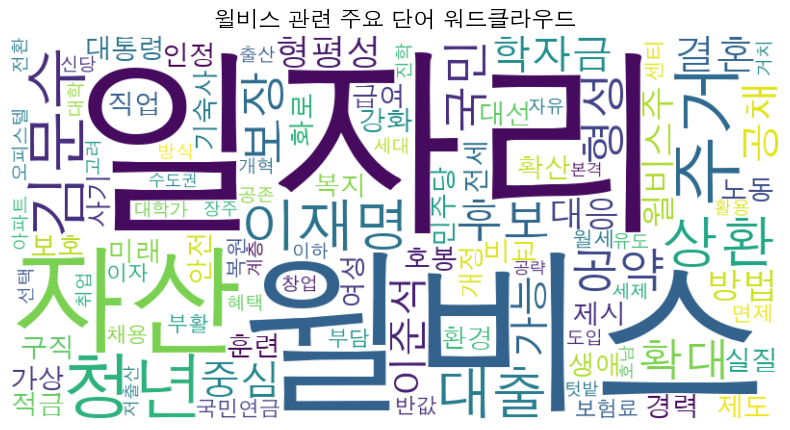

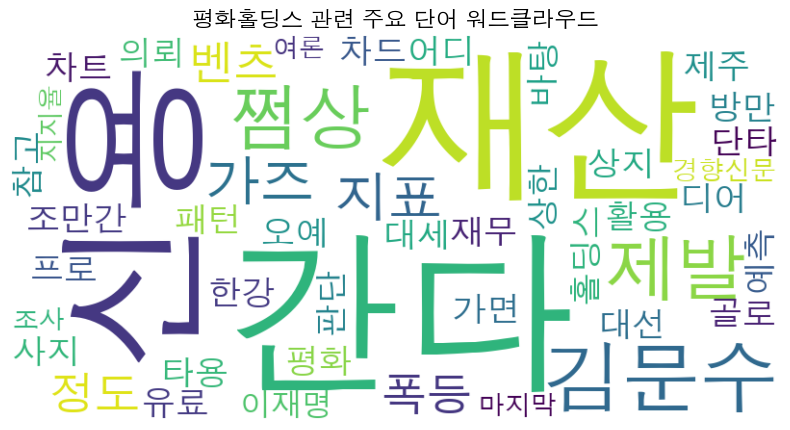

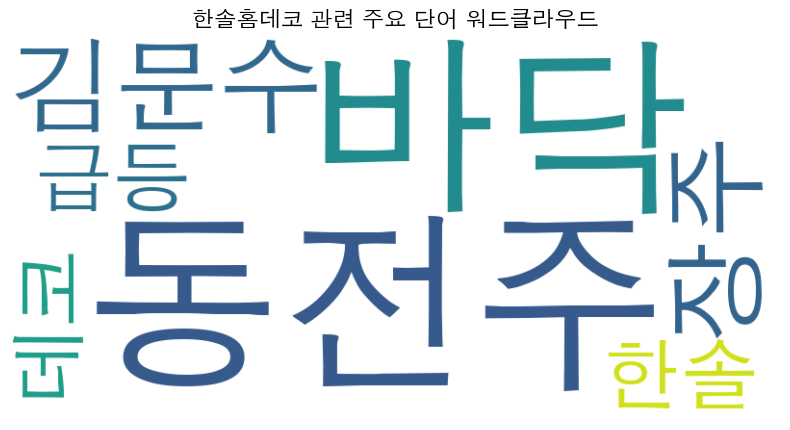

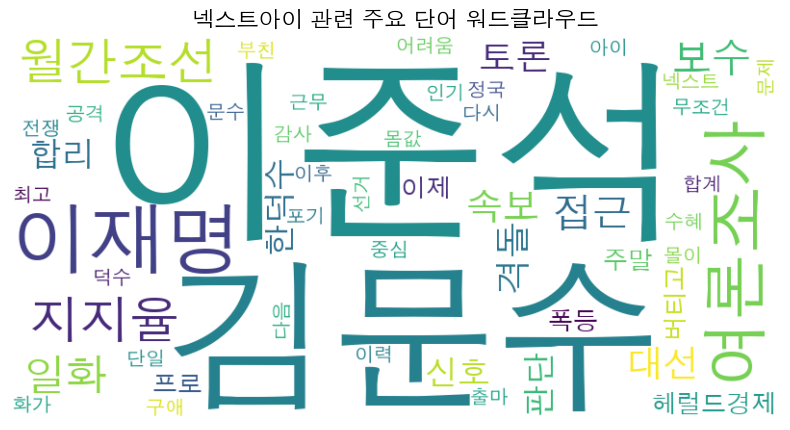

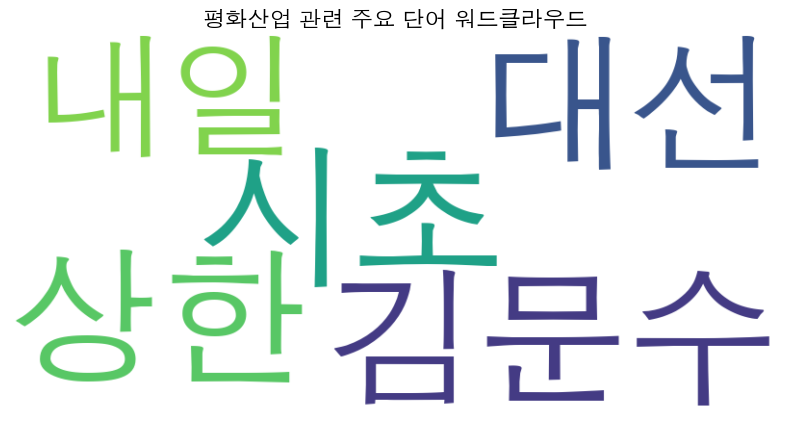

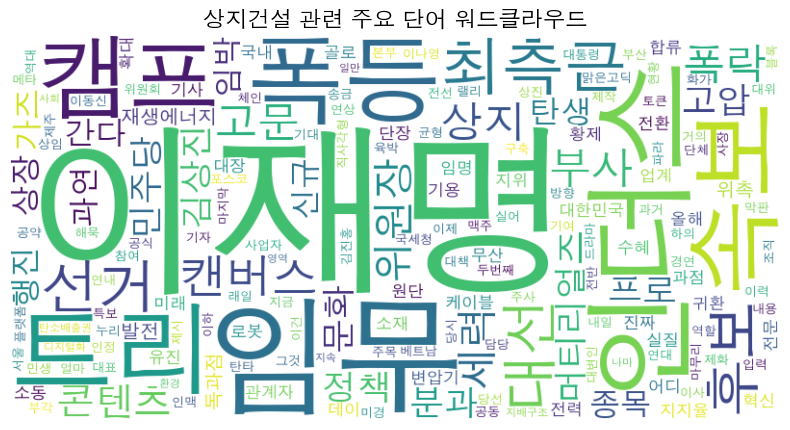

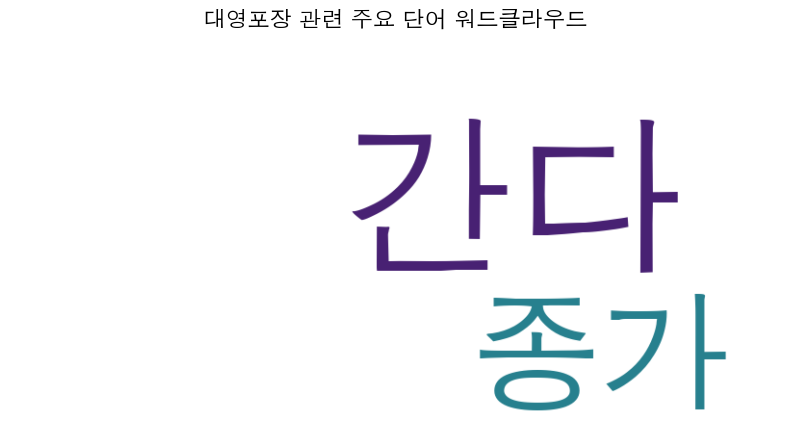

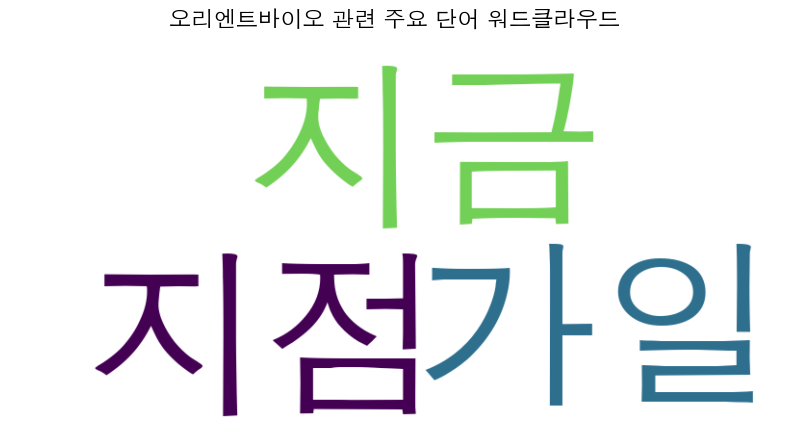

In [23]:
# 데이터 로드
df_finance_data = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})
texts = df_finance_data["kor_sentence"].tolist()

okt = Okt()

# 불용어 후보 생성 (상위 3% 빈도 단어 + 금융 특화)
all_words = []
for text in texts:
    tokens = okt.pos(text, stem=True)
    all_words.extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

counter = Counter(all_words)
top_k = int(len(counter) * 0.03)
high_freq_stopwords = set([w for w, _ in counter.most_common(top_k)])

# 금융 특화 불용어
financial_stopwords = {
    "시장", "주가", "증시", "투자", "매수", "매도", "주식", "증권", 
    "코스피", "코스닥", "기업", "경제", "금융", "지수", "수익", 
    "매출", "실적", "전망", "환율", "금리", "거래", "포트폴리오"
}

# 전체 불용어 세트
candidate_stopwords = high_freq_stopwords | financial_stopwords

def generate_wordcloud(df, stock_name, okt, candidate_stopwords):
    text_corpus = ""
    # 해당 종목의 게시글만 추출
    for _, row in df[df["종목명"] == stock_name].iterrows():
        text = f"{row['제목']} {row['내용']}"
        text_corpus += f" {text}"

    # 형태소 분석 (명사 추출)
    nouns = okt.nouns(text_corpus)
    # 불용어 제거
    filtered = [word for word in nouns if word not in candidate_stopwords and len(word) > 1]

    # 빈도 계산
    word_counts = Counter(filtered)
    if not word_counts:
        print(f"'{stock_name}'에 대해 충분한 텍스트가 없어 워드클라우드를 생성할 수 없습니다.")
        return

    # 워드클라우드 생성
    wc = WordCloud(
        font_path="/System/Library/Fonts/AppleGothic.ttf",  # macOS
        width=800, height=400,
        background_color="white"
    )
    wc.generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{stock_name} 관련 주요 단어 워드클라우드", fontsize=16)
    plt.show()

# 전체 종목에 대해 반복 수행
for stock_name in df["종목명"].unique():
    generate_wordcloud(df, stock_name, okt, candidate_stopwords)